<a href="https://colab.research.google.com/github/susant146/PyTorch_Basics_CNNmodels/blob/main/FastMRI_dataVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !pip install fastmri
!pip show fastmri
# !pip install --upgrade h5py
# !ls -lh /content/file1000875.h5


Name: fastmri
Version: 0.3.0
Summary: A large-scale dataset of both raw MRI measurements and clinical MRI images.
Home-page: https://fastmri.org/
Author: Meta/NYU fastMRI Team
Author-email: fastmri@fb.com
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: h5py, numpy, pandas, pytorch-lightning, PyYAML, runstats, scikit-image, torch, torchmetrics, torchvision
Required-by: 


# **FastMRI Data Visualization**

**Mount Drive to Access MRI Data**

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **Knee and Brain MRI Raw Data Visualization**

In [6]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import fastmri
from fastmri.data import transforms as T
from fastmri.data.subsample import RandomMaskFunc

**Read .h5 file & Check headers and Attrs**



In [7]:
file_name = '/content/drive/MyDrive/MRI_RawData(fastMRI)/file_brain_AXT2_200_6002116.h5'
hf = h5py.File(file_name)
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))
data_attrs = dict(hf.attrs)
print('Max value in the volume: ', data_attrs['max'])
print(hf['ismrmrd_header'][()])

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXT2', 'max': 0.00067767498521824, 'norm': 0.15422716780227233, 'patient_id': 'ef60235bab6b942c42b28b94ca8418727440af117e45c70a803062a7f95de751'}
Max value in the volume:  0.00067767498521824
b'<?xml version="1.0" encoding="utf-8"?>\n<ismrmrdHeader xmlns="http://www.ismrm.org/ISMRMRD" xmlns:xs="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.ismrm.org/ISMRMRD ismrmrd.xsd">\n   <studyInformation>\n      <studyTime>20:43:39</studyTime>\n   </studyInformation>\n   <measurementInformation>\n      <measurementID>45219_94487821_94487830_2034</measurementID>\n      <patientPosition>HFS</patientPosition>\n      <protocolName>AX T2_FBB</protocolName>\n      <frameOfReferenceUID>1.3.12.2.1107.5.2.19.45219.1.20190429203637183.0.0.4984</frameOfReferenceUID>\n   </measurementInformation>\n   <acquisitionSystemInformation>\n      <systemVendor>SIEMEN

In [8]:
# Check the k-space data and the corresponding RSS image
volume_kspace = hf['kspace'][()] #Read all the slices
rss_img = hf['reconstruction_rss'][()]

print(f'k-space Data dimension vol*no. coils*h*w: {volume_kspace.shape}')
print(f'Images vol*h*w: {rss_img.shape}')

k-space Data dimension vol*no. coils*h*w: (16, 16, 768, 396)
Images vol*h*w: (16, 384, 384)


**Display one slice kspace data and corresponding image data**

Slice K-Space:  (16, 768, 396)


Text(0.5, 1.0, 'RSS and CC Image of Slice')

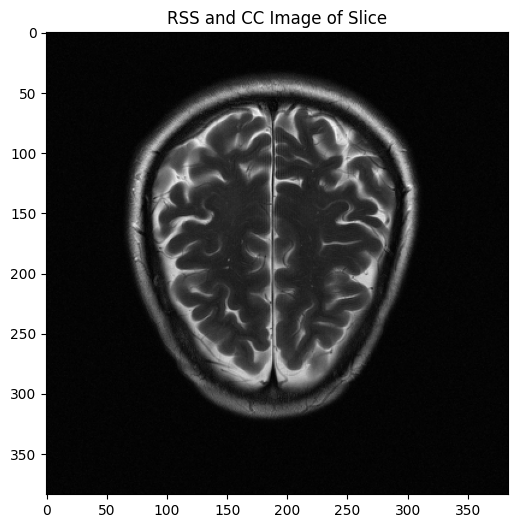

In [9]:
sliceN = 8
slice_kspace = volume_kspace[sliceN]
print('Slice K-Space: ', slice_kspace.shape)
plt.figure(figsize=(6,6))
plt.imshow(rss_img[sliceN,:,:], cmap='gray')
plt.title('RSS and CC Image of Slice')

In [10]:
plt.rcParams['figure.figsize'] = [12, 12]
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(4, 4, i + 1)
        plt.imshow(data[num], cmap=cmap)

**k-Space Data Visualization**

Single slice dimension:  (16, 768, 396)
Single slice dtype:  complex64
Single slice single coil k-space value:  (-4.232861e-06+6.333692e-06j)


Text(0.5, 1.0, 'k-space Mag. single slice single coil data')

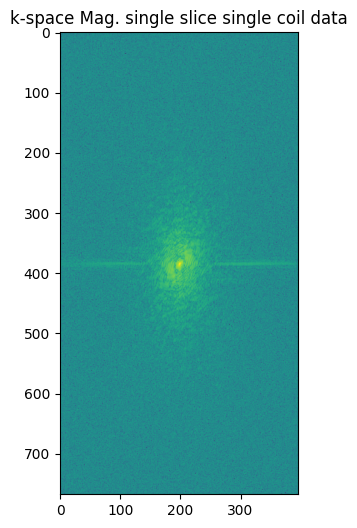

In [11]:
# Single value in k-space data
print('Single slice dimension: ', slice_kspace.shape)
print('Single slice dtype: ', slice_kspace.dtype)
print('Single slice single coil k-space value: ', slice_kspace[10, 230, 40])

# For complex value we need to display the magnitude
coilN = 7
plt.figure(figsize=(6,6))
plt.imshow(np.log(np.abs(slice_kspace[coilN]) + 1e-9))
plt.title('k-space Mag. single slice single coil data')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


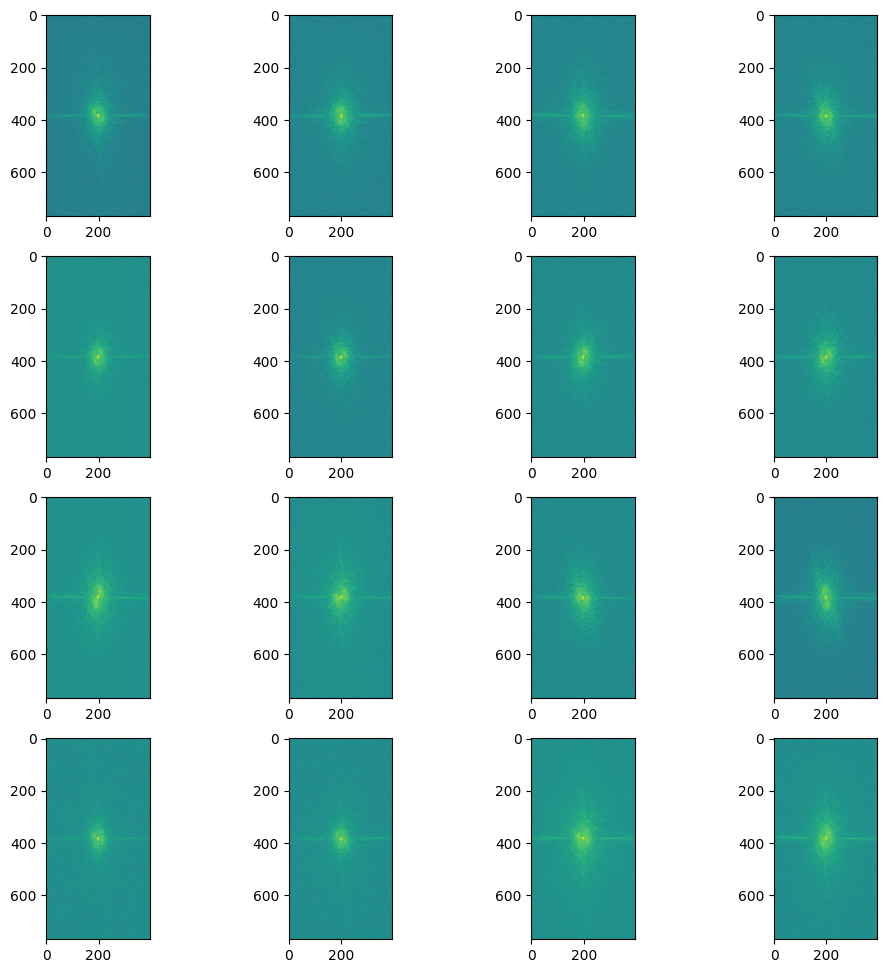

In [12]:
# Visualize all coil k-space data using special definition
#Coil k-space data.
num_coils = slice_kspace.shape[0]
coil = np.linspace(0,num_coils-1, num=num_coils)
coil = coil.astype(int)
print(coil)
show_coils(np.log(np.abs(slice_kspace) + 1e-9), coil)  # This shows all coil k-space data

**Perform Inverse FFT to get corresponding coil images**

Slice image abs shape:  torch.Size([16, 768, 396])
Slice image abs dtype:  torch.float32


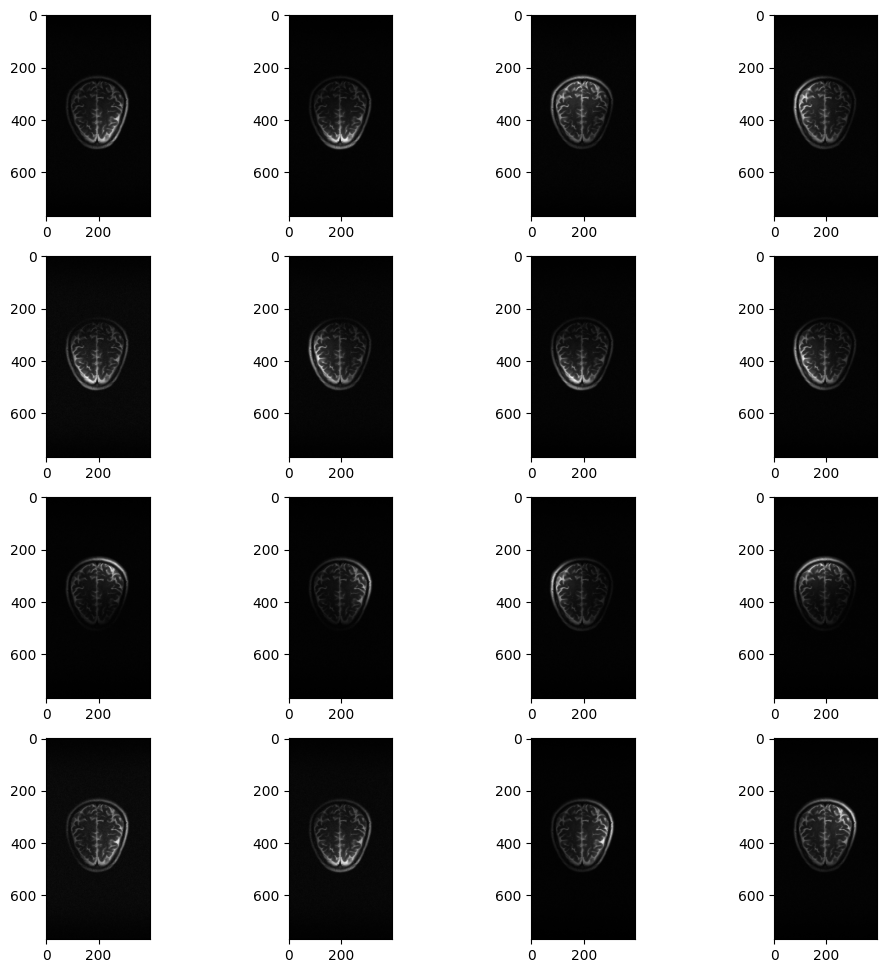

In [13]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image) # Compute absolute value to get a real image
# np.save('slice_img_abs.npy', slice_image_abs)

print('Slice image abs shape: ',slice_image_abs.shape)
print('Slice image abs dtype: ', slice_image_abs.dtype)
# Display coil images
show_coils(slice_image_abs, coil, cmap='gray')

**Root Sum of Squares (RSS)**

Text(0.5, 1.0, 'RSS-CC: Target')

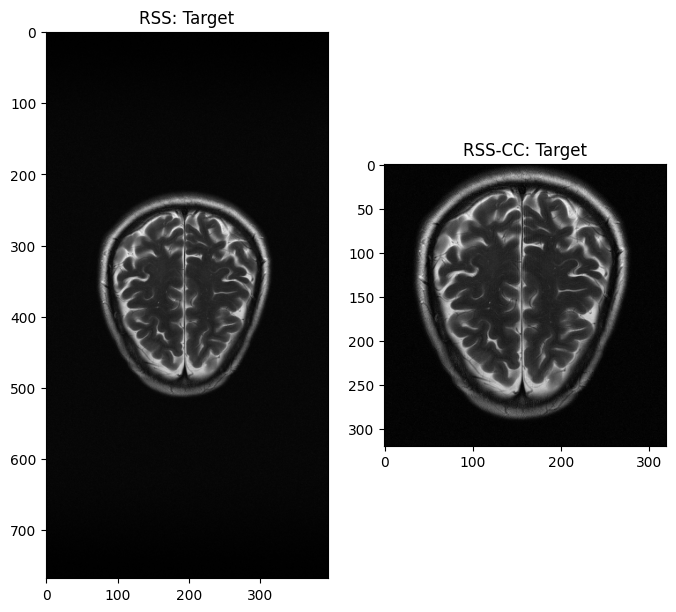

In [15]:
# use fastmri library command rss
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
plt.rcParams['figure.figsize'] = [8, 8]
plt.subplot(1,2,1)
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')
plt.title('RSS: Target')

slice_image_rss_cc = T.center_crop(slice_image_rss, [320,320])
plt.subplot(1,2,2)
plt.imshow(np.abs(slice_image_rss_cc.numpy()), cmap='gray')
plt.title('RSS-CC: Target')

**Creating subsampled Mask Function**

In [16]:
# Create the mask function object: Acc = 4 and Center data = 8%
mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])

slice_kspace2 = T.to_tensor(slice_kspace)
masked_kspace, mask, num_low_frequencies = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

print('Masked kspace Shape: ', masked_kspace.shape)
print('Mask Shape: ',mask.shape)
print(f"Number of Low Freq. {num_low_frequencies}")

Masked kspace Shape:  torch.Size([16, 768, 396, 2])
Mask Shape:  torch.Size([1, 1, 396, 1])
Number of Low Freq. 32


**Creating Undersampling Mask**

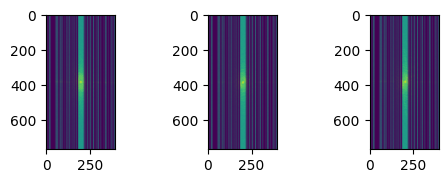

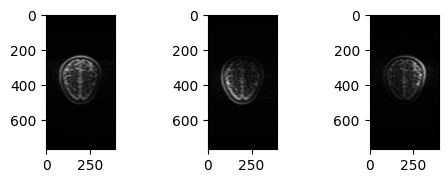

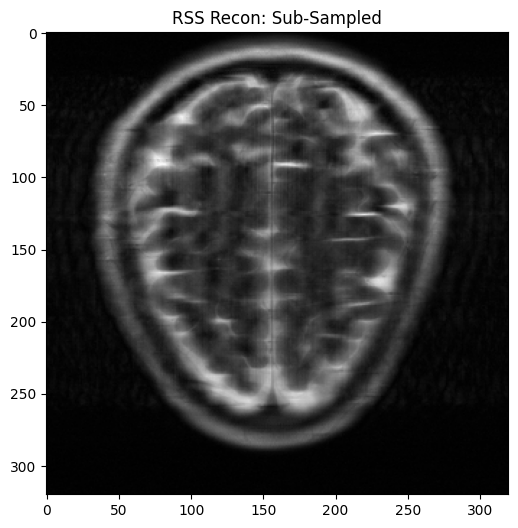

torch.Size([320, 320])


In [17]:
# Covert to complex tensor Nc,Nx,Ny: COmplex
masked_kspace_abs = fastmri.complex_abs(masked_kspace)
masked_kspace_abs = masked_kspace_abs.numpy()
show_coils(np.log(masked_kspace_abs+1e-9), [2, 5, 9])

sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
show_coils(sampled_image_abs, [2, 5, 9], cmap='gray')

sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)
sampled_img_rss_cc = T.center_crop(sampled_image_rss, [320,320])
plt.figure(figsize = (6,6))
plt.imshow(np.abs(sampled_img_rss_cc.numpy()), cmap='gray')
plt.title('RSS Recon: Sub-Sampled')
plt.show()

und_img_rss_cc = T.center_crop(sampled_image_rss, [320,320])
print(und_img_rss_cc.size())

**Calculating PSNR & SSIM RSS Image**

In [18]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
rss_img = hf['reconstruction_rss'][(sliceN)]
rss_img = T.center_crop(rss_img, [320,320])
sampled_crop_img_rss1 = sampled_img_rss_cc.numpy()

psnrVal = peak_signal_noise_ratio(rss_img, sampled_crop_img_rss1, data_range=rss_img.max() - rss_img.min())
ssimVal = structural_similarity(rss_img, sampled_crop_img_rss1, data_range=rss_img.max() - rss_img.min())
print('PSNR: ', psnrVal)
print('SSIM: ', ssimVal)

PSNR:  24.109151899020862
SSIM:  0.7550909300863713


In [19]:
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

!nvidia-smi

cpu
/bin/bash: line 1: nvidia-smi: command not found
